#Initialization:

In [1]:
import pandas as pd

import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

In [11]:
from google.colab import drive
drive.mount('/content/drive')
path1 = '/content/drive/MyDrive/VU/project_flatlands/flatland_train.npz'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Load & scale data:
data = np.load(path1)
X = data['X']
y = data['y']

y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X / 255.      # Scale down to range [0, 1]


In [4]:
# take a look at sample and data shapes:
print(X[1])
print(X.shape)
print(X[1].shape)
print(y.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(array([1381.,    0., 2853.,    0.,    0., 1868.,    0., 2137.,    0.,
        1761.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

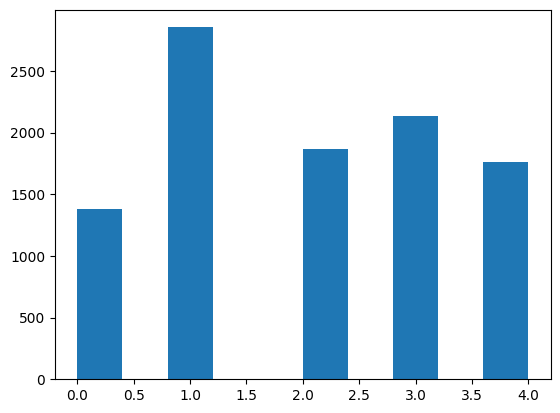

In [101]:
# Check distribution of targets:
plt.hist(y)

#Data Preparation:

In [13]:
def augment_dataset(X, y):
    # Initialize lists to store augmented images and labels
    X_augmented = []
    y_augmented = []

    for img, label in zip(X, y):
        # Original Image
        X_augmented.append(img)
        y_augmented.append(label)

        # Rotate 90 degrees
        X_augmented.append(np.rot90(img))
        y_augmented.append(label)

        # Rotate 180 degrees
        X_augmented.append(np.rot90(img, 2))
        y_augmented.append(label)

        # Rotate 270 degrees
        X_augmented.append(np.rot90(img, 3))
        y_augmented.append(label)

        # Flip vertically
        X_augmented.append(np.flipud(img))
        y_augmented.append(label)

    return np.array(X_augmented), np.array(y_augmented)

# Apply augmentation
X_augmented, y_augmented = augment_dataset(X, y)

print(f"Original dataset shape: X={X.shape}, y={y.shape}")
print(f"Augmented dataset shape: X_augmented={X_augmented.shape}, y_augmented={y_augmented.shape}")

Original dataset shape: X=(10000, 50, 50), y=(10000,)
Augmented dataset shape: X_augmented=(50000, 50, 50), y_augmented=(50000,)


In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.1, random_state=42)

In [15]:
y_train.shape

(49995,)

# Model:

In [4]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), input_shape=[50, 50, 1]))               # 3 * 2D convolutional layers with batch normalizations + a dense layer with dropout
model.add(BatchNormalization(axis=-1))   # Axis -1 is always the features axis
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy",                           # for categorization problems (Adam with "best" learning rate ofc:> )
              optimizer=Adam(learning_rate=3e-4),
              metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_9 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 batch_normalization_10 (Ba  (None, 46, 46, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_8 (Activation)   (None, 46, 46, 32)       

#Train loop:

In [ ]:
# Train the model:
model.fit(X_train, y_train, batch_size=64, epochs=18)

Epoch 1/30
391/391 [==============================] - 594s 2s/step - loss: 1.0426 - accuracy: 0.5777
Epoch 2/30
391/391 [==============================] - 589s 2s/step - loss: 0.3875 - accuracy: 0.8854
Epoch 3/30
 72/391 [====>.........................] - ETA: 8:22 - loss: 0.2852 - accuracy: 0.9291

In [137]:
# Save the model
model.save('model_keras_360.h5')

#Test model:

In [123]:
# Load the model:
model = load_model('model_keras_360.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 0.3683 - accuracy: 0.9737
Test accuracy: 0.9736999869346619
